<a href="https://colab.research.google.com/github/G-Conard/ds595-final-project/blob/main/FeatureEngineeringon2ndWeatherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pylab as py
import random
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import concurrent.futures
from tabulate import tabulate
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import FastICA
from numpy import savetxt
from numpy import loadtxt
import datetime
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.base import clone
import csv

import warnings


torch.manual_seed(50) # this makes results reproducable

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#this is a check to see if a GPU machine that pytorch can use for training
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
else:
    print('CUDA *not* available')

CUDA *not* available


In [108]:
!pip install pandas
import pandas as pd


In [109]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/G-Conard/ds595-final-project/main/Weatherdata25.csv')

In [110]:
raw_data=raw_data.dropna()

In [111]:
print(raw_data.head())

   OutdoorTemperature(C)  Heat Index (C)  Dew Point (Â°C)  Wind Speed (km/hr)  \
0                   34.3            43.0             25.4                 4.7   
1                   34.0            43.0             25.7                 2.6   
2                   34.4            43.3             25.5                 1.1   
3                   34.5            43.6             25.6                 1.8   
4                   33.9            42.3             25.3                 0.0   

   Wind Gust (km/hr)  Max Daily Gust (km/hr)  Wind Direction (Â°)  \
0                5.5                    14.8                  350   
1                3.5                    14.8                   55   
2                1.8                    14.8                    0   
3                5.5                    14.8                   38   
4                0.0                    14.8                   89   

   Hourly Rain (mm/hr)  Event Rain (mm)  Daily Rain (mm)  Weekly Rain (mm)  \
0                  0

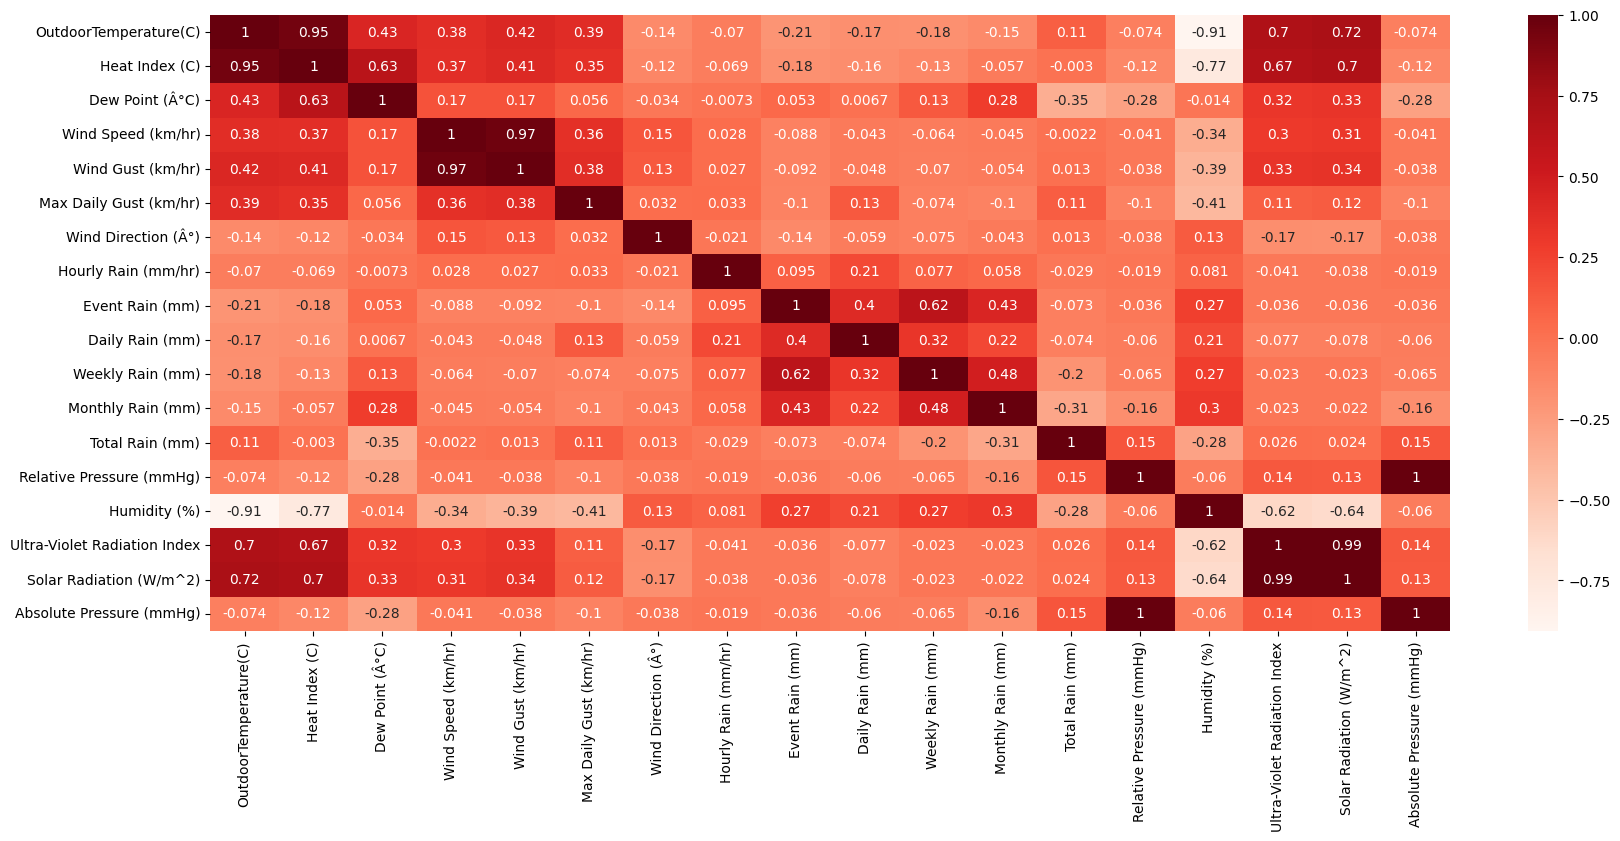

In [112]:
#Heat Map
plt.figure(figsize=(20,8))
cor = raw_data.corr()
sns.heatmap(cor, annot=True,cmap=plt.cm.Reds)
plt.show()

KeyboardInterrupt: 

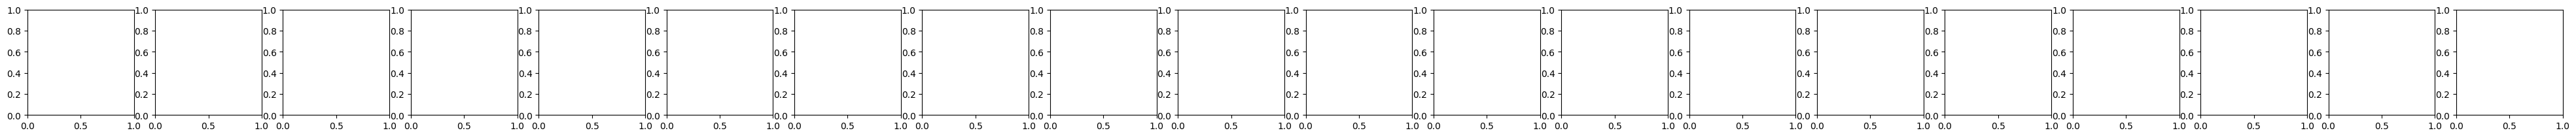

In [ ]:
#Pair  - This takes several minutes to run so we can skip this the next time we run everything
#Confirms removal of rain fall measures and wind chill
sns.pairplot(raw_data)

In [113]:
raw_data1 = raw_data.drop(['Hourly Rain (mm/hr)','Event Rain (mm)','Daily Rain (mm)','Weekly Rain (mm)','Monthly Rain (mm)','Total Rain (mm)'], axis=1)
print(raw_data1.head())

   OutdoorTemperature(C)  Heat Index (C)  Dew Point (Â°C)  Wind Speed (km/hr)  \
0                   34.3            43.0             25.4                 4.7   
1                   34.0            43.0             25.7                 2.6   
2                   34.4            43.3             25.5                 1.1   
3                   34.5            43.6             25.6                 1.8   
4                   33.9            42.3             25.3                 0.0   

   Wind Gust (km/hr)  Max Daily Gust (km/hr)  Wind Direction (Â°)  \
0                5.5                    14.8                  350   
1                3.5                    14.8                   55   
2                1.8                    14.8                    0   
3                5.5                    14.8                   38   
4                0.0                    14.8                   89   

   Relative Pressure (mmHg)  Humidity (%)  Ultra-Violet Radiation Index  \
0                     7

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


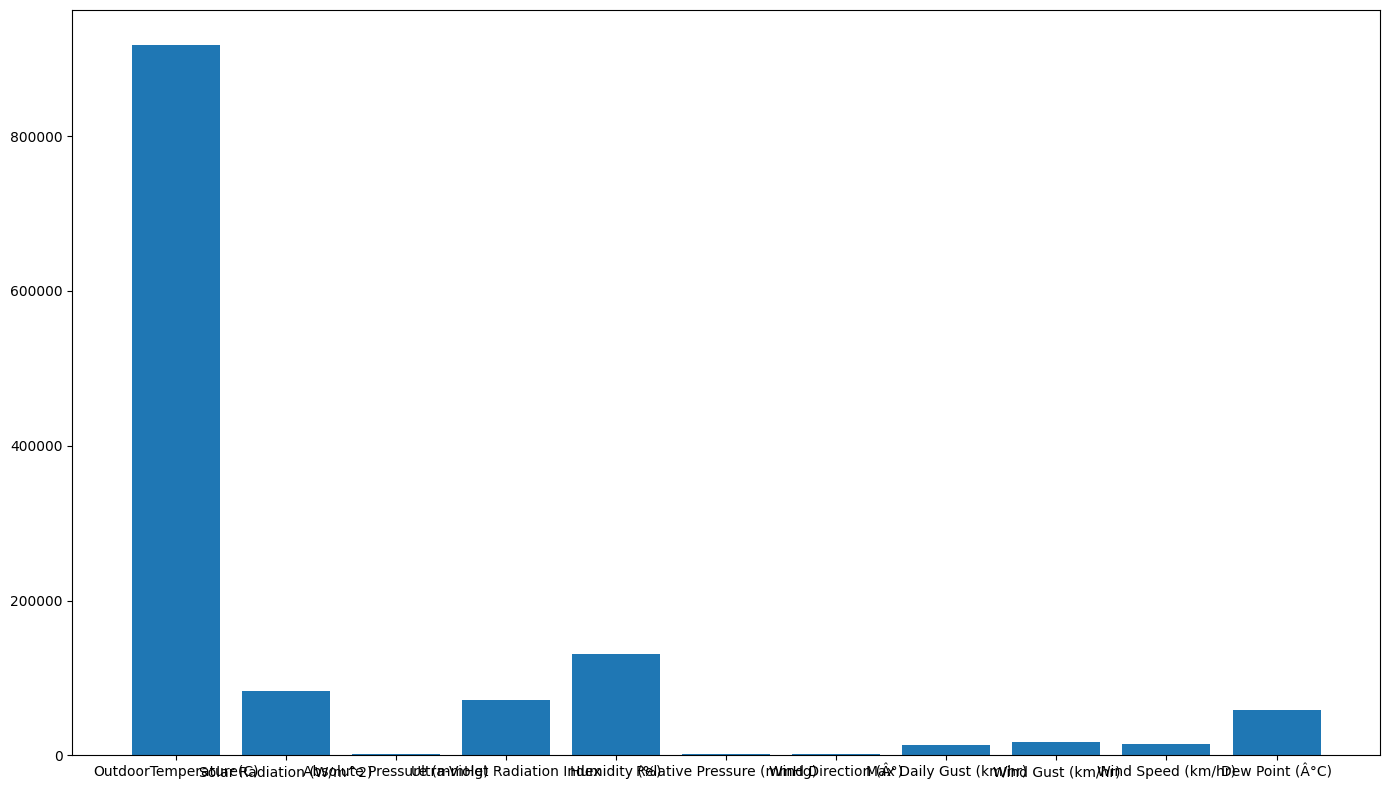

,OutdoorTemperature(C),Heat Index (C),Dew Point (Â°C),Wind Speed (km/hr),Wind Gust (km/hr),Max Daily Gust (km/hr),Wind Direction (Â°),Hourly Rain (mm/hr),Event Rain (mm),Daily Rain (mm),Weekly Rain (mm),Monthly Rain (mm),Total Rain (mm),Relative Pressure (mmHg),Humidity (%),Ultra-Violet Radiation Index,Solar Radiation (W/m^2),Absolute Pressure (mmHg)
count,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000,88755.000000
mean,28.907009,34.884646,25.910055,1.647222,2.380810,13.026777,207.296873,0.269103,12.522061,2.445117,22.501411,81.645093,1334.936764,756.376285,85.067726,1.275410,153.976962,755.926266
std,3.044383,6.639851,1.331241,2.280960,3.109833,6.731383,132.916235,3.292720,31.278843,9.423466,40.776818,103.430545,704.143543,1.327573,12.260325,2.277268,249.686194,1.327967
min,23.000000,23.700000,16.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.300000,752.000000,41.000000,0.000000,0.000000,751.500000
25%,26.500000,27.700000,25.100000,0.000000,0.000000,7.200000,85.000000,0.000000,0.000000,0.000000,0.000000,1.300000,635.300000,755.500000,77.000000,0.000000,0.000000,755.000000
50%,28.100000,34.200000,25.900000,0.300000,1.800000,13.000000,231.000000,0.000000,0.000000,0.000000,4.100000,38.100000,1317.800000,756.400000,89.000000,0.000000,1.200000,755.900000
75%,31.200000,40.400000,26.800000,2.900000,3.500000,18.300000,340.000000,0.000000,7.800000,0.000000,26.200000,125.200000,2058.200000,757.300000,95.000000,2.000000,218.600000,756.800000
max,37.700000,55.000000,30.200000,18.700000,27.700000,36.700000,359.000000,147.600000,224.000000,156.800000,213.800000,422.700000,2104.600000,761.300000,99.000000,15.000000,1847.500000,760.900000


In [114]:
#Analize the individual predictors and their correlations with the target variable
#Leads to removing absolute barometric pressure, barometric pressure, wind direction, dew point

#the Feature to predict in the dataset, and the Column predictors in the datasets
Feature = ["Heat Index (C)"]
Labels = ['OutdoorTemperature(C)', 'Solar Radiation (W/m^2)', 'Absolute Pressure (mmHg)', 'Ultra-Violet Radiation Index', 'Humidity (%)',
          'Relative Pressure (mmHg)','Wind Direction (Â°)','Max Daily Gust (km/hr)',
          'Wind Gust (km/hr)','Wind Speed (km/hr)', 'Dew Point (Â°C)']


plt.figure(figsize=(14,8))
Temp_x=raw_data[Labels]
Temp_y=raw_data[Feature]
selectKbest = SelectKBest(score_func=f_regression, k='all')
Temp_fit = selectKbest.fit(Temp_x,Temp_y)
plt.bar(x=Temp_x.columns,height=Temp_fit.scores_)
plt.tight_layout()
plt.show()

raw_data.describe()

In [115]:
#Removed only the worst features, left else
raw_data2 = raw_data1.drop(['Absolute Pressure (mmHg)', 'Relative Pressure (mmHg)' ,'Wind Direction (Â°)', 'Max Daily Gust (km/hr)', 'Dew Point (Â°C)'], axis=1)
print(raw_data2.head())

   OutdoorTemperature(C)  Heat Index (C)  Wind Speed (km/hr)  \
0                   34.3            43.0                 4.7   
1                   34.0            43.0                 2.6   
2                   34.4            43.3                 1.1   
3                   34.5            43.6                 1.8   
4                   33.9            42.3                 0.0   

   Wind Gust (km/hr)  Humidity (%)  Ultra-Violet Radiation Index  \
0                5.5            60                           2.0   
1                3.5            62                           2.0   
2                1.8            60                           1.0   
3                5.5            60                           1.0   
4                0.0            61                           2.0   

   Solar Radiation (W/m^2)  
0                    261.1  
1                    247.2  
2                    179.9  
3                    202.1  
4                    240.3  


In [123]:
#4 Unique that match original data
raw_data4= raw_data2.drop(['Wind Speed (km/hr)','Ultra-Violet Radiation Index'], axis=1)
print(raw_data4.head())

   OutdoorTemperature(C)  Heat Index (C)  Wind Gust (km/hr)  Humidity (%)  \
0                   34.3            43.0                5.5            60   
1                   34.0            43.0                3.5            62   
2                   34.4            43.3                1.8            60   
3                   34.5            43.6                5.5            60   
4                   33.9            42.3                0.0            61   

   Solar Radiation (W/m^2)  
0                    261.1  
1                    247.2  
2                    179.9  
3                    202.1  
4                    240.3  


In [122]:
#Two features -- not temp. or humidity
raw_data_only2= raw_data2.drop(['OutdoorTemperature(C)', 'Wind Speed (km/hr)','Ultra-Violet Radiation Index','Humidity (%)'], axis=1)
print(raw_data_only2.head())

   Heat Index (C)  Wind Gust (km/hr)  Solar Radiation (W/m^2)
0            43.0                5.5                    261.1
1            43.0                3.5                    247.2
2            43.3                1.8                    179.9
3            43.6                5.5                    202.1
4            42.3                0.0                    240.3


raw_data --> matches original

raw_data1 --> matches original (removed all rain measures)

raw_data2 --> matches features removed after K best as closely to original data as possible

raw_data3 --> No raw_data3 --> those same features did not exist in this data

raw_data4 --> 4 unique features - matches oroginal data

raw_data_only2 --> uses 2 non temp or humidity features - matches 2 selected in original data
